In [1]:
import pandas as pd

df_train = pd.read_csv("unfair_tos_data/unfair_tos_train.csv")
df_val = pd.read_csv("unfair_tos_data/unfair_tos_validation.csv")
df_test = pd.read_csv("unfair_tos_data/unfair_tos_test.csv")

# Combinar si quieres analizar el corpus completo inicialmente
df_full = pd.concat([df_train, df_val, df_test], ignore_index=True)

In [3]:
def parse_space_separated_label_list(label_str):
    """
    Parsea un string de etiquetas como '[3 2 1]' o '[]' a una lista de enteros.
    Maneja valores None o no-string devolviendo una lista vacía.
    """
    if pd.isna(label_str) or not isinstance(label_str, str):
        return []

    # Quitar corchetes y espacios extra al inicio/final
    cleaned_str = label_str.strip().strip('[]').strip()

    if not cleaned_str:  # Si el string queda vacío después de limpiar (ej. era solo '[]' o ' [ ] ')
        return []

    # Dividir por espacios y convertir a enteros
    try:
        return [int(num_str) for num_str in cleaned_str.split()]
    except ValueError:
        # Si algo no es un número, devuelve lista vacía o maneja el error como prefieras
        print(f"Advertencia: No se pudo parsear '{label_str}' a una lista de enteros. Se devuelve lista vacía.")
        return []

# Aplicar la función de parseo personalizada
df_full['labels_list'] = df_full['labels'].apply(parse_space_separated_label_list)

print("\nDataFrame con 'labels_list' parseada:")
print(df_full[['labels', 'labels_list']])
print("-" * 30)


# Nombres de las etiquetas en el ORDEN CORRECTO que identificaste
label_names = [
    'Limitation of liability', # Índice 0
    'Unilateral termination',  # Índice 1
    'Unilateral change',       # Índice 2
    'Content removal',         # Índice 3
    'Contract by using',       # Índice 4
    'Choice of law',           # Índice 5
    'Jurisdiction',            # Índice 6
    'Arbitration'              # Índice 7
]

# Crear columnas one-hot (o multi-hot) para cada etiqueta
if 'labels_list' in df_full.columns:
    for i, label_name in enumerate(label_names):
        df_full[label_name] = df_full['labels_list'].apply(lambda x_list: 1 if i in x_list else 0)
    print("\nDataFrame con columnas one-hot:")
    print(df_full.head())
else:
    print("Columna 'labels_list' no generada. Verifica el parsing.")

# Ahora puedes continuar con el resto de tus análisis (frecuencia, co-ocurrencia, etc.)
# usando las columnas one-hot generadas o la columna 'labels_list'.


DataFrame con 'labels_list' parseada:
     labels labels_list
0        []          []
1        []          []
2        []          []
3        []          []
4        []          []
...     ...         ...
9409     []          []
9410     []          []
9411     []          []
9412     []          []
9413    [6]         [6]

[9414 rows x 2 columns]
------------------------------

DataFrame con columnas one-hot:
                                                text labels labels_list  \
0  notice to california subscribers : you may can...     []          []   
1  if you subscribed using your apple id , refund...     []          []   
2  if you wish to request a refund , please visit...     []          []   
3  if you subscribed using your google play store...     []          []   
4  key changes in this version : we 've included ...     []          []   

   Limitation of liability  Unilateral termination  Unilateral change  \
0                        0                       0          

In [7]:
df_full

,text,labels,labels_list,Limitation of liability,Unilateral termination,Unilateral change,Content removal,Contract by using,Choice of law,Jurisdiction,Arbitration
0,notice to california subscribers : you may can...,[],[],0,0,0,0,0,0,0,0
1,"if you subscribed using your apple id , refund...",[],[],0,0,0,0,0,0,0,0
2,"if you wish to request a refund , please visit...",[],[],0,0,0,0,0,0,0,0
3,if you subscribed using your google play store...,[],[],0,0,0,0,0,0,0,0
4,key changes in this version : we 've included ...,[],[],0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9409,"code § 1789.3 , you may report complaints to t...",[],[],0,0,0,0,0,0,0,0
9410,"pursuant to 815 ilcs 414/1 .5 ( c ) , for tran...",[],[],0,0,0,0,0,0,0,0
9411,the aaa 's rules are available at www.adr.org ...,[],[],0,0,0,0,0,0,0,0
9412,such complaints shall be decided by an indepen...,[],[],0,0,0,0,0,0,0,0



Frecuencia de cada etiqueta (con orden corregido):
Limitation of liability    296
Unilateral termination     236
Unilateral change          188
Content removal            118
Contract by using          117
Choice of law               70
Jurisdiction                68
Arbitration                 44
dtype: int64


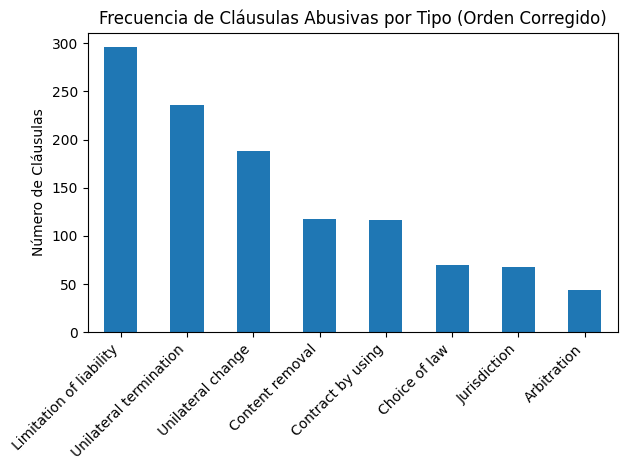

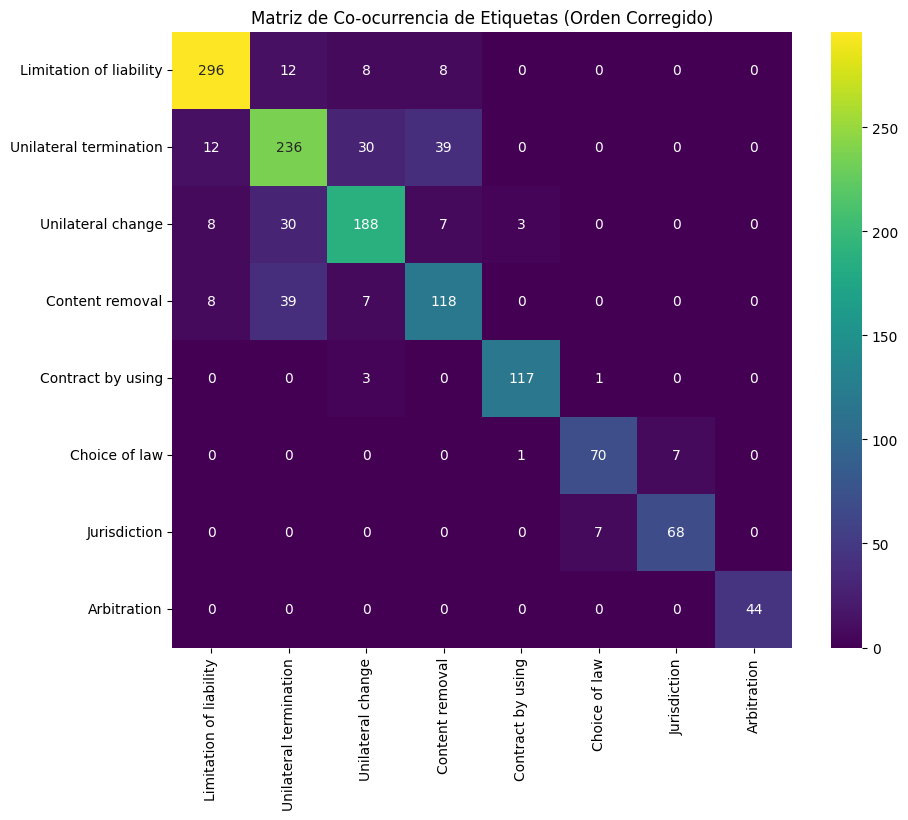

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...



Palabras más frecuentes en cláusulas de 'Limitation of liability':
use            173
services       153
liability      139
content        131
damages        121
service        117
liable         115
loss           109
including       93
third           77
party           71
shall           67
law             67
whether         60
damage          60
event           58
data            55
arising         55
extent          54
responsible     50
dtype: int64


[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Análisis de Frecuencia de Etiquetas:
if label_names[0] in df_full.columns: # Verificar si la primera etiqueta correcta existe
    label_counts = df_full[label_names].sum().sort_values(ascending=False)
    print("\nFrecuencia de cada etiqueta (con orden corregido):")
    print(label_counts)

    label_counts.plot(kind='bar')
    plt.title('Frecuencia de Cláusulas Abusivas por Tipo (Orden Corregido)')
    plt.ylabel('Número de Cláusulas')
    plt.xticks(rotation=45, ha="right") # Para mejor visualización de nombres largos
    plt.tight_layout() # Ajustar layout
    plt.show()
else:
    print("Las columnas de etiquetas individuales no se crearon. Verifica el paso de parsing.")

# Co-ocurrencia de Etiquetas:
if label_names[0] in df_full.columns:
    df_labels_one_hot = df_full[label_names]
    co_occurrence_matrix = df_labels_one_hot.T.dot(df_labels_one_hot)

    plt.figure(figsize=(10, 8))
    sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="viridis",
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Matriz de Co-ocurrencia de Etiquetas (Orden Corregido)')
    plt.show()
else:
    print("Las columnas de etiquetas individuales para co-ocurrencia no se crearon.")

# Análisis de Palabras Frecuentes para una etiqueta específica (ej. 'Limitation of liability')
if 'Limitation of liability' in df_full.columns and not df_full[df_full['Limitation of liability'] == 1].empty:
    text_limitation_liability = df_full[df_full['Limitation of liability'] == 1]['text']

    # ... (el resto del código para CountVectorizer como en la respuesta anterior) ...
    # Asegúrate de usar 'english' para las stopwords ya que UNFAIR-ToS está en inglés
    try:
        stopwords_en = nltk.corpus.stopwords.words('english')
    except LookupError:
        nltk.download('stopwords')
        stopwords_en = nltk.corpus.stopwords.words('english')

    vectorizer = CountVectorizer(stop_words=stopwords_en, max_features=20)
    X = vectorizer.fit_transform(text_limitation_liability)
    word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    print("\nPalabras más frecuentes en cláusulas de 'Limitation of liability':")
    print(word_freq_df.sum().sort_values(ascending=False))
